####                                 FRAUD DETECTION
###### - Works without imbalanced-learn (uses class weights), but will use SMOTE automatically if available
###### - Proper train/validation/test split to avoid data leakage
###### - Clean preprocessing via ColumnTransformer + Pipeline
###### - Solid metrics: ROC-AUC, PR-AUC, F1, precision/recall, confusion matrix
###### - Threshold tuning on validation set
###### - Model comparison: Logistic Regression, Random Forest, XGBoost (optional)
###### - Saves the best model

In [29]:
# ============================
# 0) Imports
# ============================
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [30]:
# Optional: XGBoost (if installed). If not, we skip it gracefully.
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Optional: SMOTE (if installed). If not, we fall back to class weights.
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except Exception:
    HAS_SMOTE = False

import matplotlib.pyplot as plt

In [31]:
# ============================
# Load your data
# ============================
# If you already have a DataFrame named df in memory, comment the CSV read below
CSV_PATH = "/kaggle/input/financial-dataset-for-fraud-detection-in-a-comapny/Fraud.csv"  # <-- change to your file path or keep if you will inject df manually
if Path(CSV_PATH).exists():
    df = pd.read_csv(CSV_PATH)
else:
    # Create a placeholder to avoid NameError if user already has df in memory
    try:
        df
    except NameError:
        raise FileNotFoundError(
            "No CSV found at CSV_PATH and no DataFrame `df` in memory. Set CSV_PATH correctly or define `df`."
        )

print("Data shape:", df.shape)
print("Columns:", list(df.columns))

Data shape: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [32]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())
df.drop_duplicates(inplace=True)

(6362620, 11)
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Text(0, 0.5, 'Count')

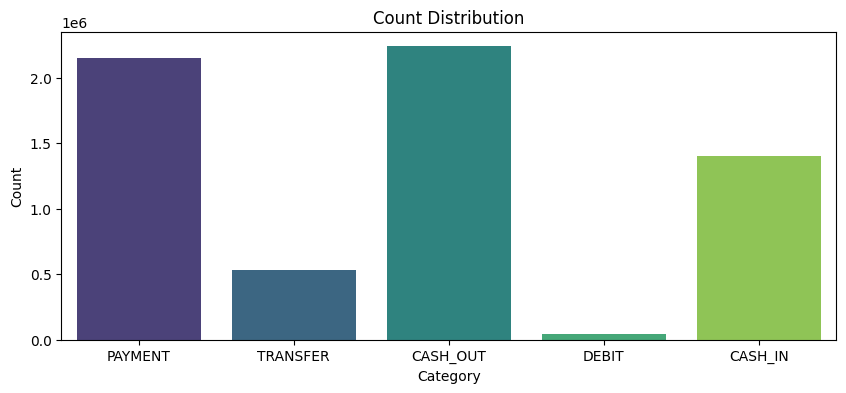

In [33]:
# Create a figure with specified size and plot a count distribution
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df,  
    x='type',  
    palette='viridis'  
)
plt.title("Count Distribution")  
plt.xlabel("Category") 
plt.ylabel("Count")  

[]

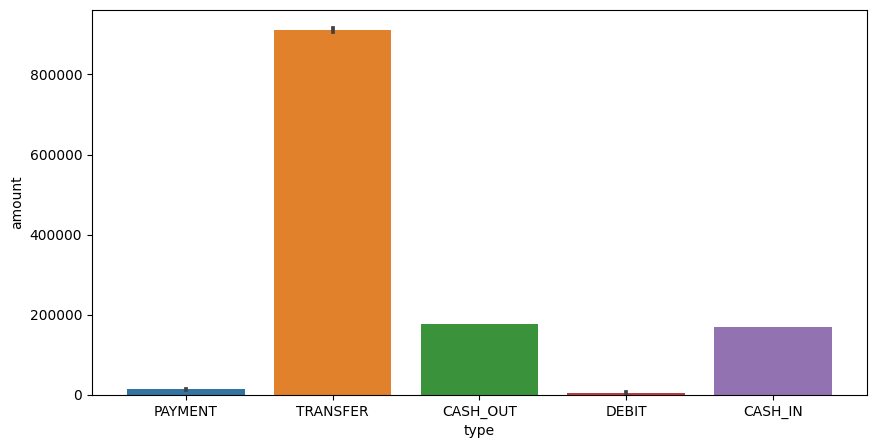

In [34]:
plt.figure(figsize=(10,5))
sns.barplot(x="type",y="amount",data=df)
plt.plot()

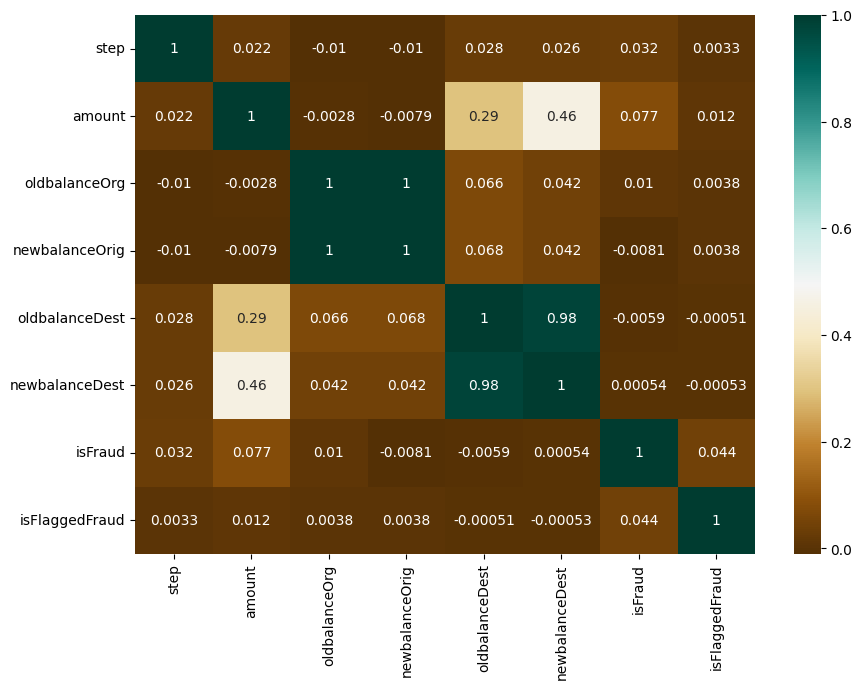

In [35]:
corrmat = df.corr(numeric_only=True)
top_corr_features = corrmat.index
plt.figure(figsize=(10,7))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="BrBG")

In [36]:
# checking how many case are farud and nofraud
fraud = df[df['isFraud'] == 1]
Nfraud = df[df['isFraud'] == 0]

max_fraud=fraud['amount'].max()
max_nofraud=Nfraud['amount'].max()


print("max fraud amonut",max_fraud)
print("max nofraud amonut",max_nofraud)
print("total fraud cases",fraud.shape[0])
print("total fraud cases",Nfraud.shape[0])

max fraud amonut 10000000.0
max nofraud amonut 92445516.64
total fraud cases 8213
total fraud cases 6354407


<Axes: xlabel='type', ylabel='count'>

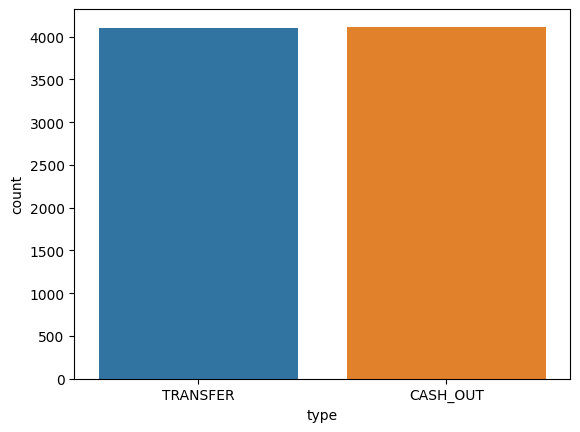

In [37]:
sns.countplot(x='type', data=fraud)


[]

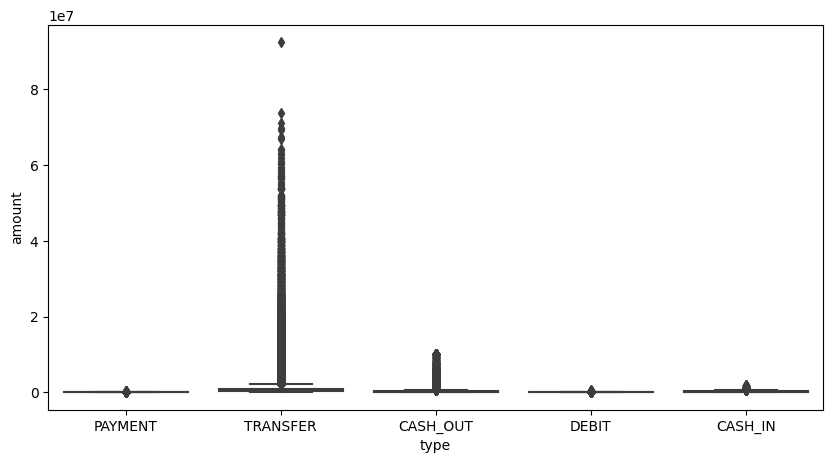

In [38]:
#checkimh outliers
plt.figure(figsize=(10,5))
sns.boxplot(x="type",y="amount",data=df)
plt.plot()

In [39]:
# ============================
# Basic cleaning: drop obvious leakage/IDs (adjust as needed)
# ============================
DROP_COLS = [c for c in ["nameOrig", "nameDest"] if c in df.columns]
if DROP_COLS:
    df = df.drop(columns=DROP_COLS)

# Ensure target column exists
TARGET = "isFraud"
assert TARGET in df.columns, f"Target column '{TARGET}' not found!"


In [40]:
# ============================
# Split features/target
# ============================
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Identify categorical & numeric columns
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

Numeric cols: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Categorical cols: ['type']


In [41]:
# ============================
# Train/Validation/Test split (stratified)
#    We do: Train+Val (80%) / Test (20%), then split Train into Train (75% of 80%) and Val (25% of 80%)
# ============================
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25 * 0.8 = 0.2

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (3817572, 8) Val: (1272524, 8) Test: (1272524, 8)


In [42]:
# ============================
# Preprocessing pipeline
# ============================
num_tf = Pipeline(steps=[("scaler", StandardScaler(with_mean=False))])  # with_mean=False safe for sparse
cat_tf = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols),
    ]
)

In [43]:
# ============================
# Optional resampling on TRAIN ONLY (to avoid leakage)
# ============================
# We'll build a helper to optionally apply SMOTE after preprocessing but before the classifier.

USE_SMOTE = HAS_SMOTE  # set to False to avoid smote even if available
if USE_SMOTE:
    print("SMOTE is available and will be applied on the training fold only.")
else:
    print("SMOTE not available or disabled. Using class_weight='balanced' in models.")

SMOTE not available or disabled. Using class_weight='balanced' in models.


In [44]:
# ============================
# Define candidate models
# ============================
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight=None if USE_SMOTE else "balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight=None if USE_SMOTE else "balanced_subsample",
    ),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="logloss",
        scale_pos_weight=1.0,  # class weight handled via SMOTE or balanced in others
    )

In [45]:
# ============================
# Fit models (with optional SMOTE) & evaluate on validation set
# ============================
from sklearn.utils import shuffle as sk_shuffle

val_scores = []
trained_models = {}

for name, clf in models.items():
    print(f"\n===== Training {name} =====")

    # Build end-to-end pipeline (preprocess -> model)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])

    if USE_SMOTE:
        # Fit preprocess on X_train, then transform to arrays for SMOTE
        X_train_enc = pipe.named_steps["preprocess"].fit_transform(X_train, y_train)
        X_val_enc = pipe.named_steps["preprocess"].transform(X_val)

        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train_enc, y_train)

        # Fit classifier on balanced encoded data
        pipe.named_steps["model"].fit(X_train_bal, y_train_bal)

        # Validation probabilities
        val_proba = pipe.named_steps["model"].predict_proba(X_val_enc)[:, 1]
    else:
        # No SMOTE: just fit the whole pipeline; class_weight handles imbalance
        pipe.fit(X_train, y_train)
        val_proba = pipe.predict_proba(X_val)[:, 1]

    # Default 0.5 threshold for now
    val_pred = (val_proba >= 0.5).astype(int)

    # Metrics
    roc = roc_auc_score(y_val, val_proba)
    ap = average_precision_score(y_val, val_proba)  # PR-AUC
    f1 = f1_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)

    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {ap:.4f} | F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f}")

    val_scores.append({
        "Model": name,
        "ROC_AUC": roc,
        "PR_AUC": ap,
        "F1@0.5": f1,
        "Precision@0.5": prec,
        "Recall@0.5": rec,
    })

    trained_models[name] = pipe

val_df = pd.DataFrame(val_scores).sort_values(by=["PR_AUC", "ROC_AUC"], ascending=False)
print("\nValidation leaderboard (sorted by PR_AUC then ROC_AUC):\n", val_df)



===== Training LogReg =====
ROC-AUC: 0.9939 | PR-AUC: 0.6080 | F1: 0.0511 | P: 0.0262 | R: 0.9671

===== Training RandomForest =====
ROC-AUC: 0.9995 | PR-AUC: 0.9448 | F1: 0.8578 | P: 0.9804 | R: 0.7625

===== Training XGBoost =====
ROC-AUC: 0.9999 | PR-AUC: 0.9650 | F1: 0.8924 | P: 0.9633 | R: 0.8313

Validation leaderboard (sorted by PR_AUC then ROC_AUC):
           Model   ROC_AUC    PR_AUC    F1@0.5  Precision@0.5  Recall@0.5
2       XGBoost  0.999928  0.965036  0.892449       0.963303    0.831303
1  RandomForest  0.999534  0.944792  0.857828       0.980423    0.762485
0        LogReg  0.993919  0.608019  0.051055       0.026220    0.967113


In [46]:
# ============================
# Choose best model by PR-AUC (more informative for fraud) and tune threshold on validation set
# ============================
best_name = val_df.iloc[0]["Model"]
best_model = trained_models[best_name]
print(f"\nBest model by PR-AUC: {best_name}")

# Get validation probabilities again (ensure consistency with SMOTE/no-SMOTE)
if USE_SMOTE:
    X_train_enc = best_model.named_steps["preprocess"].fit_transform(X_train, y_train)
    X_val_enc = best_model.named_steps["preprocess"].transform(X_val)
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_enc, y_train)
    best_model.named_steps["model"].fit(X_train_bal, y_train_bal)
    val_proba = best_model.named_steps["model"].predict_proba(X_val_enc)[:, 1]
else:
    best_model.fit(X_train, y_train)
    val_proba = best_model.predict_proba(X_val)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)
# Maximize F1 on validation
f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[max(best_idx - 1, 0)]  # thr has len-1 vs prec/rec
print(f"Best threshold on validation by F1: {best_thr:.4f} | F1: {np.nanmax(f1s):.4f}")



Best model by PR-AUC: XGBoost
Best threshold on validation by F1: 0.3001 | F1: 0.9049


In [47]:
# ============================
#  Final evaluation on TEST with tuned threshold
# ============================
if USE_SMOTE:
    # Refit on full Train (X_train+X_val) with SMOTE, then evaluate on X_test
    X_tr_full = pd.concat([X_train, X_val], axis=0)
    y_tr_full = pd.concat([y_train, y_val], axis=0)

    X_tr_enc = best_model.named_steps["preprocess"].fit_transform(X_tr_full, y_tr_full)
    X_test_enc = best_model.named_steps["preprocess"].transform(X_test)

    sm = SMOTE(random_state=42)
    X_tr_bal, y_tr_bal = sm.fit_resample(X_tr_enc, y_tr_full)

    best_model.named_steps["model"].fit(X_tr_bal, y_tr_bal)
    test_proba = best_model.named_steps["model"].predict_proba(X_test_enc)[:, 1]
else:
    # Refit on Train+Val without SMOTE
    X_tr_full = pd.concat([X_train, X_val], axis=0)
    y_tr_full = pd.concat([y_train, y_val], axis=0)

    best_model.fit(X_tr_full, y_tr_full)
    test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply tuned threshold
test_pred = (test_proba >= best_thr).astype(int)

# Metrics on test
roc = roc_auc_score(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)
f1 = f1_score(y_test, test_pred)
prec = precision_score(y_test, test_pred)
rec = recall_score(y_test, test_pred)
print("\n===== FINAL TEST METRICS (tuned threshold) =====")
print(f"ROC-AUC: {roc:.4f} | PR-AUC: {ap:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("\nClassification Report:\n", classification_report(y_test, test_pred, digits=4))



===== FINAL TEST METRICS (tuned threshold) =====
ROC-AUC: 0.9998 | PR-AUC: 0.9681 | F1: 0.9112 | Precision: 0.9232 | Recall: 0.8996
Confusion Matrix:
 [[1270758     123]
 [    165    1478]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999   1270881
           1     0.9232    0.8996    0.9112      1643

    accuracy                         0.9998   1272524
   macro avg     0.9615    0.9497    0.9556   1272524
weighted avg     0.9998    0.9998    0.9998   1272524



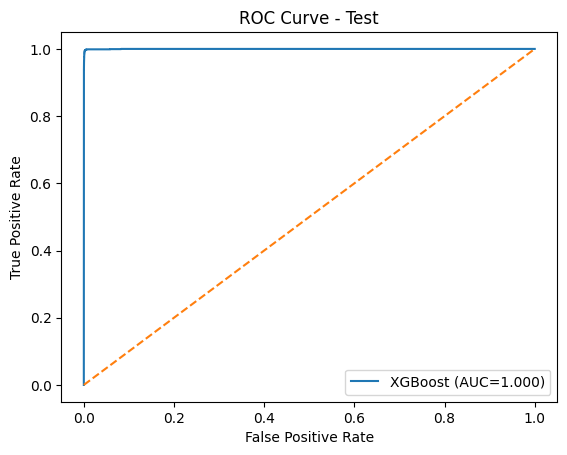

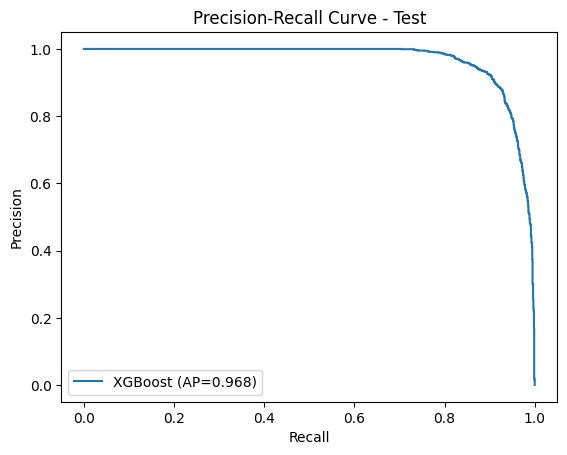

Saved best model to: best_fraud_model_XGBoost.joblib


In [48]:
# ============================
#  Curves
# ============================
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test")
plt.legend();
plt.show()

# Precision-Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, test_proba)
plt.figure()
plt.plot(rec_curve, prec_curve, label=f"{best_name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test")
plt.legend();
plt.show()

# ============================
#  Save best model
# ============================
from joblib import dump
MODEL_PATH = f"best_fraud_model_{best_name}.joblib"
dump(best_model, MODEL_PATH)
print(f"Saved best model to: {MODEL_PATH}")
